PDS Algorithmic Design
====================

The PDS (Product Distribution System) is an obsolete data transfer engine gradually being replaced, but still deployed in a few Storm Prediction Centres (offices of Environment and Climate Change Canada.) other systems place files in input directories, and PDS has an array of configurations identifying which other destinations files need to be sent to.

It is a sort of inspiration for Sundew. The lack of source code meant that it's functionality was deduced and reverse engineered to to produce later products.
It is a design of it's time, the 1980's for use on large UNIX servers.


* pdsReceiver, scans a directory feeds things to dispatcher.
* pdsDispatcher, scans sender configurations, and queues files for senders.
* pdsSender... does the sending.

The initial deployments were on HP-UX HP-9000 UNIX servers, but it was ported to Linux in the early 2000's, without substantial changes.

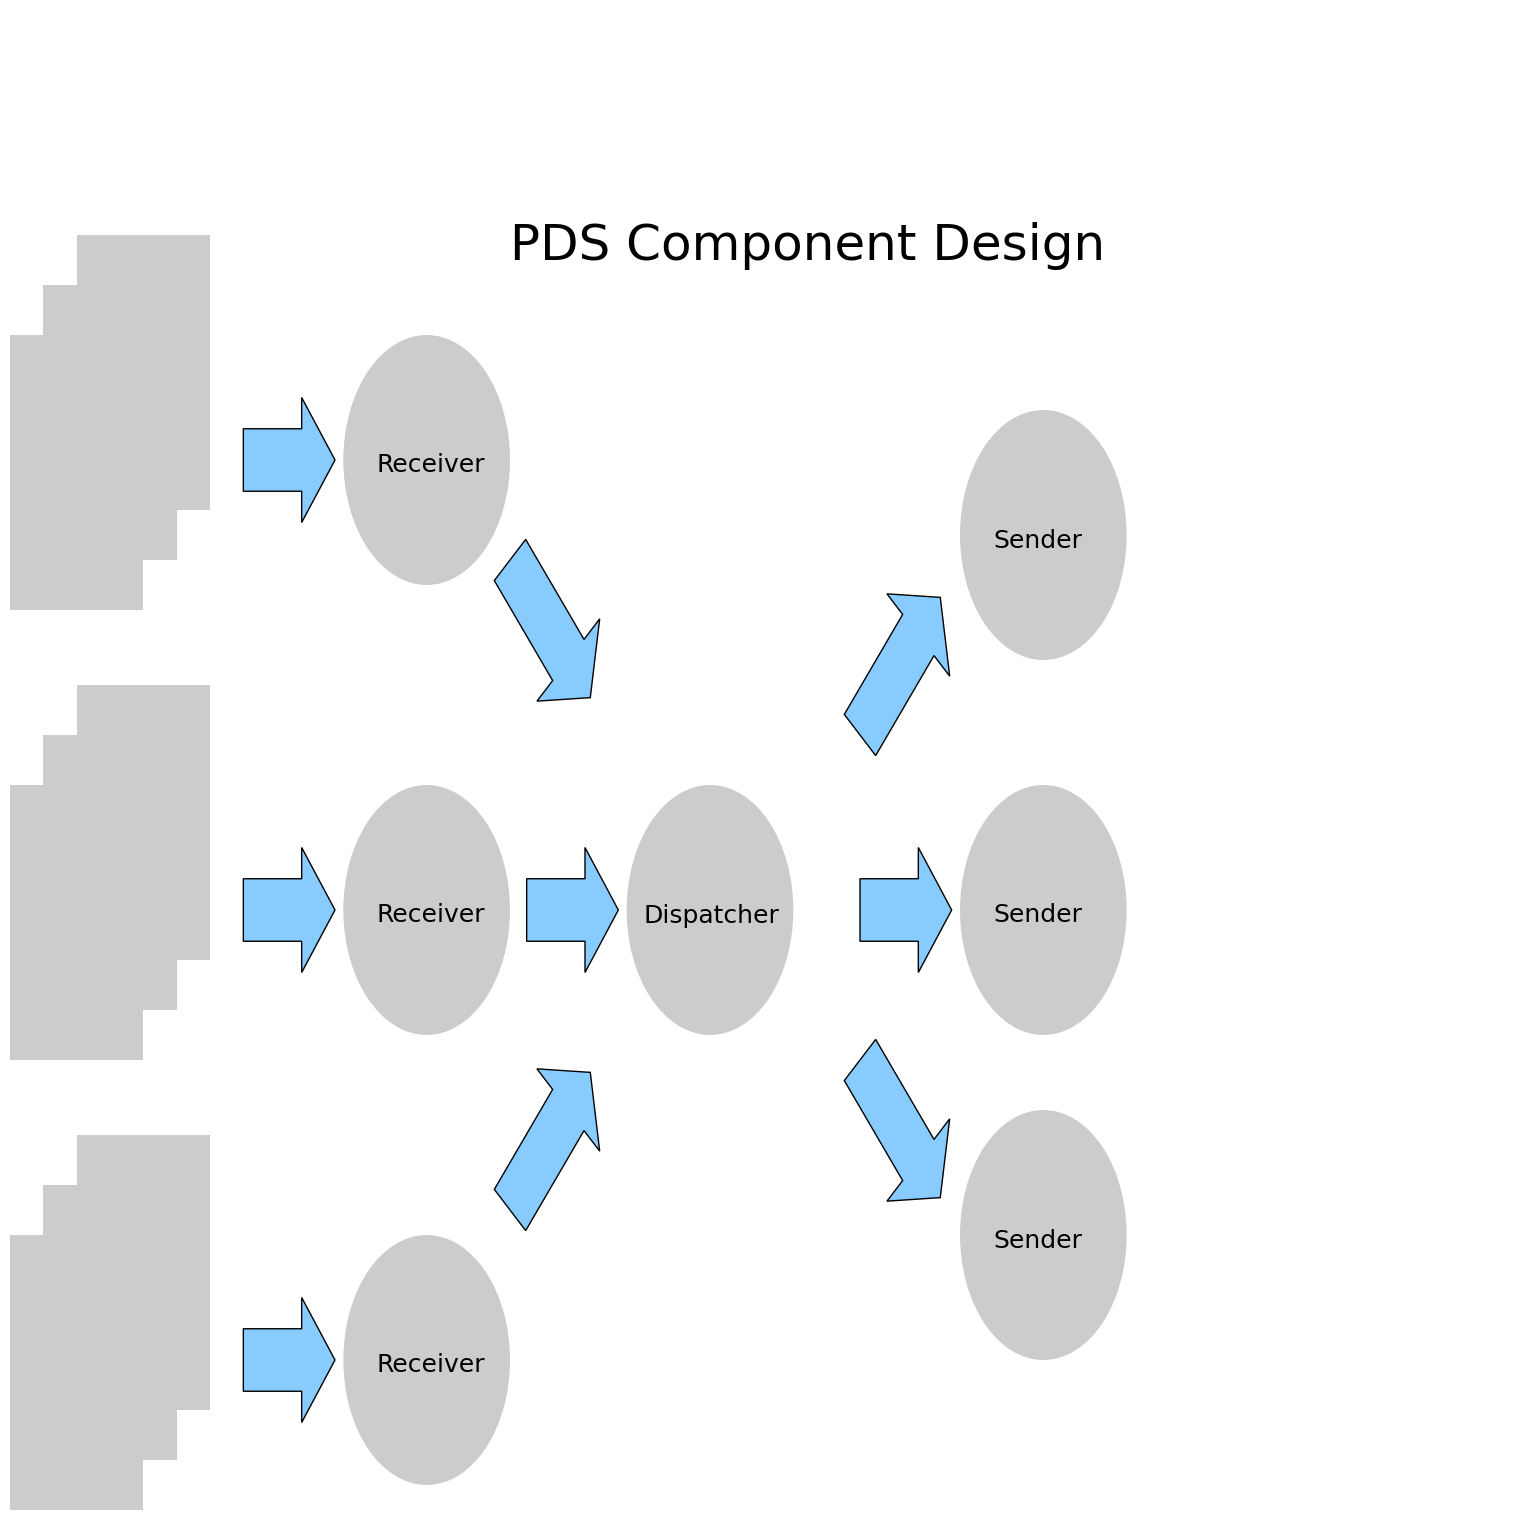

In [105]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

def directory_polygon(x,y,box_bg,arrow1):
   return [ Rectangle((x, y), 0.8, 1.1, zorder=1, fc=box_bg),
               Rectangle((x+0.2, y+0.2), 0.8, 1.1, zorder=2, fc=box_bg),
               Rectangle((x+0.4, y+0.4), 0.8, 1.1, zorder=3, fc=box_bg),
            FancyArrow(x+1.4,y+0.6, 0.35, 0, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2),
            Circle((x+2.5, y+0.6), 0.5, fc=box_bg)
          ]
   
def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(15, 15), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    
    x=0
    y=3.6
    patches = []
    patches.extend(directory_polygon(x,y,box_bg,arrow1))        
    y=0
    patches.extend(directory_polygon(x,y,box_bg,arrow1))  
    y=1.8
    patches.extend(directory_polygon(x,y,box_bg,arrow1))
    
    patches.extend( [ FancyArrow(3.1,2.4,0.35, 0, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                      Circle((4.2, 2.4), 0.5, fc=box_bg),
                     FancyArrow(3.0,1.2,0.35, 0.4, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                     FancyArrow(3.0,3.8,0.35, -0.4, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                     FancyArrow(5.1,2.4,0.35, 0, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                     FancyArrow(5.1,1.8,0.35, -0.4, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                     FancyArrow(5.1,3.1,0.35, 0.4, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2 ),
                     Circle((6.2, 3.9), 0.5, fc=box_bg),
                     Circle((6.2, 2.4), 0.5, fc=box_bg),
                     Circle((6.2, 1.1), 0.5, fc=box_bg)
                    ])
    for p in patches:
        ax.add_patch(p)
    plt.text(3.8,2.35, 'Dispatcher', fontsize=18)
    plt.text(2.2,0.55, 'Receiver', fontsize=18)
    plt.text(2.2,2.35, 'Receiver', fontsize=18)
    plt.text(2.2,4.15, 'Receiver', fontsize=18)
    plt.text(5.9,1.05, 'Sender', fontsize=18)
    plt.text(5.9,2.35, 'Sender', fontsize=18)
    plt.text(5.9,3.85, 'Sender', fontsize=18)
create_base()
plt.text(3.0, 5, 'PDS Component Design',fontsize=36)
plt.show()

Receiver
------------

Scans an input directory, uses IPC to tell the dispatcher about it.
Log activities.

Dispatcher
---------------

Processes the files arriving as notified by the dispatcher using IPC.

For each file:

* Examine the accept/reject (imask/emask) rules for each sending process.
  The decision to put files in a sender directory was based on evaluating
  sequential regular expression patterns for each sender.  Assume 10 regular
  expressions per sender.
* As a single dispatcher is running, it can assign ensure file names are unique then they are placed in sender directories.

place a file in the directory each sender uses. Log activities.


Sender
----------

Scan the sending directory, send files, remove them.
Log activities.


Design Decisions/Assumptions
--------------------------------------------

* Developers were asked to provide a single log for the entire system. 
* on the order of 10 receivers.
* on the order of 100 senders.
* Assume 10 regex's per sender.
* it was the eighties... so 1 or two cpus. Servers were very expensive, clustering for HA was a thing, but scaling was accomplished by bigger, more expensive servers.


Routing 1 Product
--------------------------

* PDS dispatcher routing for all receivers at once.) 
* represents a scale out vs. previous deployments.
* units of as the number of regular expressions evaluated. (not MIPS.)


In [115]:
S=100  # number of senders to route to.
re=100 # number of regex's per sender to evaluate. 
R=10   # number of receivers.
Rp=S*re/2
RE=100
s=10 # number of senders selected by pre-routing phase.

print( f"PDS pre-routing cost {int(Rp)} regular exppression evaluations")

print( f"Assuming an average regex costs about the same as 500 instructions")
print( f"then that means the cost to route 1 product is, on average, about {int(Rp*RE)} instructions.")

Rpc= s* RE*re/2

print( f"Then add client-side second evaluation of RE's by sender: {Rpc}")

PDS pre-routing cost 5000 regular exppression evaluations
Assuming an average regex costs about the same as 500 instructions
then that means the cost to route 1 product is, on average, about 500000 instructions.
Then add client-side second evaluation of RE's by sender: 50000.0


Observations:
--------------------


* modern systems have many more cores (16 is common on single servers... ) but also clustering is common.  Clustering is scaling with multiple servers, rather than more powerful individual servers.
* In order to ensure log entries were not corrupted by different processes writing to the log at once, a locking mechanism was used to mediate access.
* The dispatcher is a single process doing all of the routing.

2004, there was a project to use PDS to replace the existing Tandem Apps application. It didn't work, PDS was too slow, so that motivated some analysis of how PDS worked. The work can be used as motivation for a discussion of application design.